In [9]:
import argparse
import math
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import time
import random
import torch.nn.functional as F
from model_utility import *
from dataset_utility import *
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from cka_utility import *
# from seaborn import heatmap

from config import Config
from models import *

import numpy as np
from plot import *
parser = argparse.ArgumentParser(description='FQ-ViT')

parser.add_argument('--model',
                    choices=[
                        'deit_tiny', 'deit_small', 'deit_base', 'vit_base',
                        'vit_large', 'swin_tiny', 'swin_small', 'swin_base'
                    ],
                    default='deit_tiny',
                    help='model')
parser.add_argument('--data', metavar='DIR',
                    default='/home/jieungkim/quantctr/imagenet',
                    help='path to dataset')
parser.add_argument('--quant', default=True, action='store_true')
parser.add_argument('--ptf', default=True)
parser.add_argument('--lis', default=True)
parser.add_argument('--quant-method',
                    default='minmax',
                    choices=['minmax', 'ema', 'omse', 'percentile'])
parser.add_argument('--mixed', default=True, action='store_true')
# TODO: 100 --> 32
parser.add_argument('--calib-batchsize',
                    default=30,
                    type=int,
                    help='batchsize of calibration set')
parser.add_argument("--mode", default=0,
                        type=int, 
                        help="mode of calibration data, 0: PSAQ-ViT, 1: Gaussian noise, 2: Real data")
# TODO: 10 --> 1
parser.add_argument('--calib-iter', default=10, type=int)
# TODO: 100 --> 200
parser.add_argument('--val-batchsize',
                    default=30,
                    type=int,
                    help='batchsize of validation set')
parser.add_argument('--num-workers',
                    default=16,
                    type=int,
                    help='number of data loading workers (default: 16)')
parser.add_argument('--device', default='cuda', type=str, help='device')
parser.add_argument('--print-freq',
                    default=100,
                    type=int,
                    help='print frequency')
parser.add_argument('--seed', default=0, type=int, help='seed')



args = parser.parse_args(args=[])
seed(args.seed)

device = torch.device(args.device)
cfg = Config(args.ptf, args.lis, args.quant_method)
# model = str2model(args.model)(pretrained=True, cfg=cfg)
# model = model.to(device)



# Note: Different models have different strategies of data preprocessing.
model_type = args.model.split('_')[0]
if model_type == 'deit':
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    crop_pct = 0.875
elif model_type == 'vit':
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)
    crop_pct = 0.9
elif model_type == 'swin':
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    crop_pct = 0.9
else:
    raise NotImplementedError
train_transform = build_transform(mean=mean, std=std, crop_pct=crop_pct)
val_transform = build_transform(mean=mean, std=std, crop_pct=crop_pct)

# Data
traindir = os.path.join(args.data, 'train')
valdir = os.path.join(args.data, 'val')

val_dataset = datasets.ImageFolder(valdir, val_transform)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=args.val_batchsize,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True,
)
# switch to evaluate mode
# model.eval()

# define loss function (criterion)
criterion = nn.CrossEntropyLoss().to(device)

train_dataset = datasets.ImageFolder(traindir, train_transform)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=10,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=True,
)




In [10]:
int8_model = model_make(args.model, args.ptf, args.lis, args.quant_method, args.device)
int4_model = model_make(args.model, args.ptf, args.lis, args.quant_method, args.device)
not_quantized_model = model_make(args.model, args.ptf, args.lis, args.quant_method, args.device)

eight_bit_config = [8]*50
#basic_net, epsilon, step_size, num_steps, bit_config, args
not_quantized_attack_net = AttackPGD(
    basic_net=not_quantized_model, 
    epsilon=0.06,
    step_size=0.01,
    num_steps=50,
    bit_config=None,
    args=args)
four_bit_config = [4]*50
seed_images, seed_labels = not_quantized_attack_net.get_seed_inputs(50, rand=False)
adv_inputs = not_quantized_attack_net.gen_adv_inputs(seed_images, seed_labels)

# int8_model = calibrate_model(args.mode, args, int8_model, train_loader, device)
int4_model = calibrate_model(args.mode, args, int4_model, train_loader, device)


# int8_model.eval()
int4_model.eval()
not_quantized_model.eval()

print()



Model: deit_tiny_patch16_224
Model: deit_tiny_patch16_224
Model: deit_tiny_patch16_224
Calibrating with real data...



In [11]:
compute_cka_with_adversarial(not_quantized_model,
                             int4_model, 
                             use_batch = True, 
                             normalize_act = False, 
                             cka_batch = 50, #원래는 cifar10 256장.
                             cka_iter = 10, 
                             result_name='cka_with_adversarial_not_quantized_int4_model_test.pkl', 
                             model1_bit_config = None,
                             model2_bit_config = four_bit_config,
                             args = args)

OutOfMemoryError: CUDA out of memory. Tried to allocate 30.00 MiB. GPU 0 has a total capacity of 7.66 GiB of which 8.81 MiB is free. Including non-PyTorch memory, this process has 7.63 GiB memory in use. Of the allocated memory 6.93 GiB is allocated by PyTorch, and 531.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

(50, 50) (12, 12)
(50, 50) (12, 12)
(50, 50) (12, 12)
(50, 50) (12, 12)
x | y : 1 1
x | y : 1 1
x | y : 1 1
x | y : 1 1
x | y : 1 1
comprehensive_Diagonal values: [1.0000001  1.         1.0000001  1.         1.0000001  1.
 0.9999999  1.         1.0000001  1.0000001  1.         1.
 1.         1.         1.0000001  0.9999999  1.         0.9999999
 1.         1.0000001  1.0000001  1.         1.         0.99999994
 1.0000001  0.9999999  1.0000001  0.99999976 0.9999999  0.99999994
 1.0000001  1.0000001  1.0000001  0.99999994 1.         1.0000001
 0.9999998  1.         0.99999994 0.9999998  0.9999999  1.
 1.         0.99999994 1.         1.         1.         0.99999994
 1.0000001  1.        ]
qkv_Diagonal values: [1.         1.         1.0000001  1.         0.9999999  1.
 0.9999999  0.99999994 0.99999994 1.         1.         1.        ]
proj_Diagonal values: [1.0000001  0.9999999  1.         1.0000001  1.         1.
 1.0000001  1.0000001  1.         0.99999994 1.         1.        ]
mlp_fc

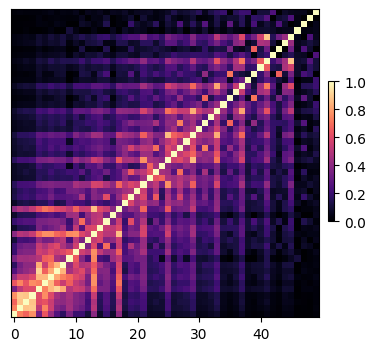

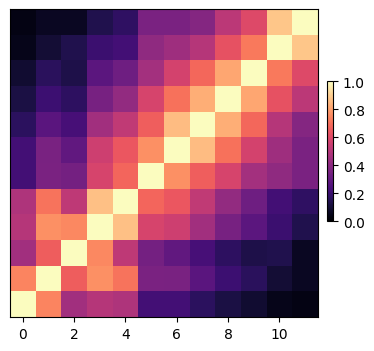

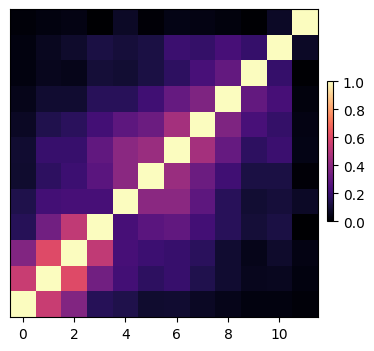

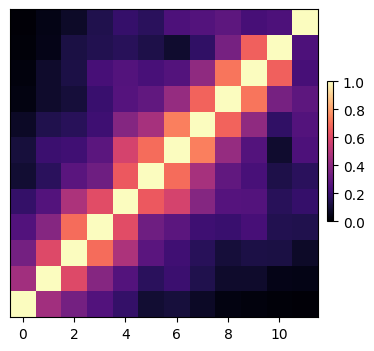

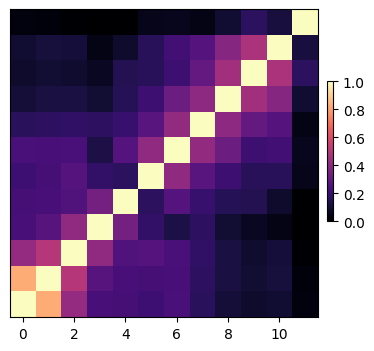

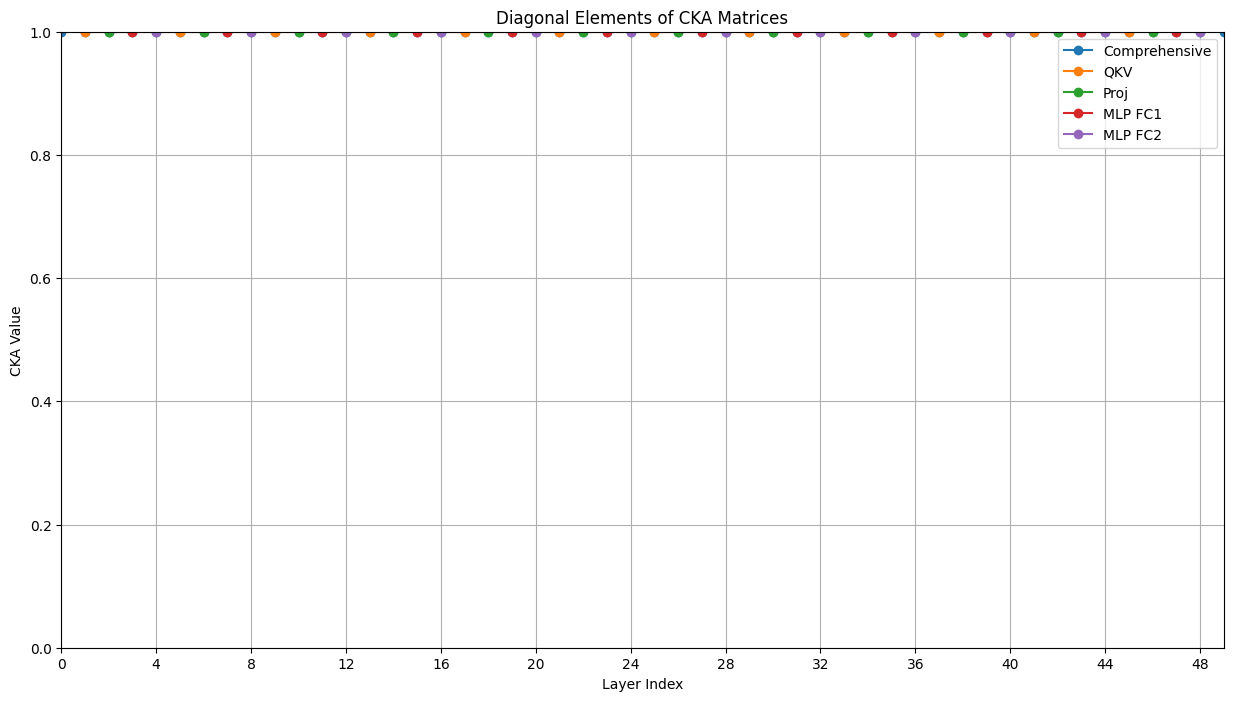

Comprehensive Diagonal values: [1.0000001  1.         1.0000001  1.         1.0000001  1.
 0.9999999  1.         1.0000001  1.0000001  1.         1.
 1.         1.         1.0000001  0.9999999  1.         0.9999999
 1.         1.0000001  1.0000001  1.         1.         0.99999994
 1.0000001  0.9999999  1.0000001  0.99999976 0.9999999  0.99999994
 1.0000001  1.0000001  1.0000001  0.99999994 1.         1.0000001
 0.9999998  1.         0.99999994 0.9999998  0.9999999  1.
 1.         0.99999994 1.         1.         1.         0.99999994
 1.0000001  1.        ]
QKV Diagonal values: [1.         1.         1.0000001  1.         0.9999999  1.
 0.9999999  0.99999994 0.99999994 1.         1.         1.        ]
Proj Diagonal values: [1.0000001  0.9999999  1.         1.0000001  1.         1.
 1.0000001  1.0000001  1.         0.99999994 1.         1.        ]
MLP FC1 Diagonal values: [1.         1.         1.         0.9999999  1.0000001  0.99999994
 0.99999976 1.0000001  1.0000001  0.9999998  0

In [8]:

plot_cka_map(
    cka_file_name= 'cka_with_adversarial_not_quantized_int4_model_test', 
    plot_name = 'cka_with_adversarial_not_quantized_int4_model_test'
    )


# 사용 예시
pickle_folder = 'cka_with_adversarial_not_quantized_int4_model_test'
#qkv, proj, mlp_fc1, mlp_fc2

comprehensive_pickle_file = f'{pickle_folder}/cka_with_adversarial_not_quantized_int4_model_test_heatmap'

qkv_pickle_file = f'{pickle_folder}/cka_qkv'
proj_pickle_file = f'{pickle_folder}/cka_proj'
mlp_fc1_pickle_file = f'{pickle_folder}/cka_mlp_fc1'
mlp_fc2_pickle_file = f'{pickle_folder}/cka_mlp_fc2'





comprehensive_diagonal = load_and_plot_diagonal(comprehensive_pickle_file)
qkv_diagonal = load_and_plot_diagonal(qkv_pickle_file)
proj_diagonal = load_and_plot_diagonal(proj_pickle_file)
mlp_fc1_diagonal = load_and_plot_diagonal(mlp_fc1_pickle_file)
mlp_fc2_diagonal = load_and_plot_diagonal(mlp_fc2_pickle_file)


# 대각 값들 출력
print("comprehensive_Diagonal values:", comprehensive_diagonal)
print("qkv_Diagonal values:", qkv_diagonal)
print("proj_Diagonal values:", proj_diagonal)
print("mlp_fc1_Diagonal values:", mlp_fc1_diagonal)
print("mlp_fc2_Diagonal values:", mlp_fc2_diagonal)



pickle_files = [
    f'{pickle_folder}/cka_with_adversarial_not_quantized_int4_model_test_test_heatmap',
    f'{pickle_folder}/cka_qkv',
    f'{pickle_folder}/cka_proj',
    f'{pickle_folder}/cka_mlp_fc1',
    f'{pickle_folder}/cka_mlp_fc2'
]

labels = ['Comprehensive', 'QKV', 'Proj', 'MLP FC1', 'MLP FC2']

plot_all_diagonals(pickle_files, labels)

# 대각 값들 출력
for pickle_file, label in zip(pickle_files, labels):
    diagonal = load_diagonal(pickle_file)
    print(f"{label} Diagonal values:", diagonal)